# Tutorial 6: Improving Learning

# ADD OVERVIEW

The training so far has been decent but not satisfactory at all. The evidence of that is that the reward function is not monotonic in the number of epochs, hence a sub-optimal strategy has been adopted.
Before saying anything else, let's have another look at some of the results we obtained.

### Training metrics for halite thresholds = {10,100,1000} and 200 epochs of 10 batches

In this first case we can see that a random agent (epoch 1, without knowing the Q-values and with $\epsilon = 0.5$)
has a better performance than the train model. At the same time we can see that the passages through the shipyard at first they increase and then they saturate between 45 and 60. With an average reward of 6000+ this makes roughly more than 100 of halite deposited for each passage. This is comprehensible since the ship cannot distinguish between 101 and 1000 of cargo, hence every time it goes over 100 of cargo it has learned to go back to the shipyard.

<img src="Support_material/halite_10_100_1000_10batches.png" >



### Training metrics for halite thresholds = {100,500,1000} and 200 epochs of 10 batches

This was the most promising agent, since at first had learned to deposit on average around 8000 of halite in 40 passages, hence 200 of cargo for each passage. This is a strange value, because if we assume for semplicity the cargo to be either equal to 100 or to 500, it means that 25% of the times was depositing 500 of halite and the other 75% of the times 100 of halite. In other words it was a peak, but not a stable configuration. At the final level we have on average roughly 42 of cargo for each passage, meaning that it was always in the lowest state of cargo. This is of course a very bad thing.

<img src="Support_material/halite_100_500_1000_10batches.png" >



### Training metrics for halite thresholds = {100,500,1000} and 200 epochs of 30 batches

Retraining with the same halite levels but with more batches for epoch has completely changed the behaviour. We would be tempted to say that it reached a stable equilibrium (even if not optimal, 7000 halite, 45 passages, 155 halite for passage), but just before the end the strategy changed again, for the worse.
<img src="Support_material/halite_100_500_1000_30batches.png" >

First of all it has become clear that the reward metric at the moment is useless (the amount of halite collected is much more intuitive as a metric) and could be replaced by the average cargo deposited per passage.

### Q-values stochasticity induced by quantization

The first thing that we have noticed is that our agent is not stable w.r.t. changes in the quantization criterion. This partially makes sense, because different quantizations imply different losses of informations, but we would like it to be more consistent. However we should enter in a discussion from a game theory perspective (agent vs stochastic environment) to better understand why this is not the case.

To understand better what is the effect of the quantization on the estimate of the Q-values we should build a simplified model to work with. <br>
Let's say we have three intervals $I_0$, $I_1$ and $I_2$ adjacent one to the other (e.g. $[0,h_1]$,$[h_1+1,h_2]$,$[h_2+1,1000]$). As it was probably clear yet, just two numbers are needed to divide in 3 intervals an original interval with given extremes. <br>

Now consider the simpler problem where our agent has just two actions: wait, W, (and collect resources) or deposit, D, (and get the reward). <br>
We also have to model the fact that choosing D each turn is bad, because actually in reality before waiting it has to move to a cell different from the shipyard in order to collect the halite. 
I do this in the following way: the reward for the D action will be equal to the halite deposited minus a certain amount due to the loss of time (say $-R_0$). 

Also we have to model both the simplified environment and how the agent observes it (because there is loss of information in the process). Since D already accounts for the loss of time of going to another cell, the simplest approximation of the environment is to think of it as composed by two cells, that of the shipyard and another one that has a certain amount of halite H. Now since in reality the agent has more than a single choice, imagine that every time the halite on the cell is generated uniformly between 1 and 1000. Coherently with our model, the agent will see only the quantized levels both for itself (C, for cargo) and of the cell (H, for halite). They will be $C_0$, $C_1$ or $C_2$ and $H_0$, $H_1$ and $H_2$ depending on the level of halite. and the choice of the intervals.

What we want to see is how the choice of $h_1$ and $h_2$ affects the performances of our agent. Here below we implement this simple algorithm.

In [1]:
#import modules and libraries
import sys
sys.path.insert(0, "../Environment/")
sys.path.insert(0, "../Modules/")
import halite_env as Env
import encode as cod
import ship 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def quantize(halite, h1, h2):
    if halite <= h1:
        return 0
    elif halite > h1 and halite <= h2:
        return 1
    else:
        return 2
    
# we have 9 states (all the combinations of C and H)
def get_enc_state(C,H):
    enc_states = np.arange(9).reshape(3,3)
    return enc_states[C,H]

In [11]:
for C in range(3):
    for H in range(3):
        print("State with C = %d and H = %d is "%(C,H), get_enc_state(C,H))

State with C = 0 and H = 0 is  0
State with C = 0 and H = 1 is  1
State with C = 0 and H = 2 is  2
State with C = 1 and H = 0 is  3
State with C = 1 and H = 1 is  4
State with C = 1 and H = 2 is  5
State with C = 2 and H = 0 is  6
State with C = 2 and H = 1 is  7
State with C = 2 and H = 2 is  8


### Game dynamics
Before the game starts:
* Define Q-values all to zero;
* Define a schedule for the epsilon decay (e.g. from $0.5$ to $10^{-2}$).

At each step we do the following:
* Sample H_true (not quantized), that is the value of halite in the cell;
* Observe C and H (both quantized);
* Choose accordingly to the eps_greedy policy which action to take (D or W);
* If D is taken, record the halite deposited in a vector (we want to know how much halite is deposited both during the episode and on average at each deposit). Give to the agent the reward C_true - R0 and then set C_true = 0.
* If W is taken, C_true = C_true + 0.25*H_true and then the reward is a standard -k*R0, with k between 0 and 1.
* Update the Q_values, with W = 0, D = 1 as encoding for the entries.

The game stops after `TOT_TURNS` turns.

In [40]:
q_values = np.zeros((9,2)) # states x actions
# our hyper-parameters are h1, h2, R0 and k
# TOT_TURNS is fixed
# epsilon has always the same schedule decay during the epochs 
h1 = 10
h2 = 100
R0 = 200
k = 0.2
TOT_TURNS = 400
MAX_EPOCHS = 100
eps = 0.2

In [45]:
def play_episode(q_values, eps, h1, h2, R0, TOT_TURNS, verbose = False):
    verbose_print = print if verbose else lambda *a, **k: None
    C_true = 0
    steps = 0
    halite_deposited = []
    while True:
        steps = steps + 1
        verbose_print("Turn number ", steps)
        H_true = np.random.randint(1000) # sample H_true between 0 and 999
        # observe state
        C = quantize(C_true, h1, h2)
        H = quantize(H_true, h1, h2)
        s_enc = get_enc_state(C,H)
        # use epsilon greedy policy to select action
        a = ship.e_greedy_policy(s_enc,q_values) # a=0 -> W, a=1 -> D
        a_dict = {0:'Wait',1:'Deposit'}
        verbose_print("Action taken: ", a_dict[a])
        # make step
        if a == 0:
            C_true = C_true + 0.25*H_true # update halite carried
            H_true -= 0.25*H_true # subtract the halite collected to the cell -> used only for computing enc_state_temp
            r = -k*R0 # assign reward
        else:
            halite_deposited.append(C_true)
            r = C_true - R0 # assign reward
            C_true = 0 # update halite carried
        # simulate which action to take
        H_tmp = quantize(H_true, h1, h2)
        C_tmp = quantize(C_true, h1, h2)
        s_enc_tmp = get_enc_state(C,H)
        # use epsilon greedy policy to select action
        a_tmp = ship.greedy_policy(s_enc_tmp, q_values)
        # update q_values
        q_values = ship.update_q_v0(s_enc, a, r, s_enc_tmp, a_tmp, q_values, alpha = 0.5, gamma = 1)

        if steps == TOT_TURNS:
            break
    halite_deposited = np.array(halite_deposited)
    tot = halite_deposited.sum()
    passages = len(halite_deposited)
    mean = tot/passages
    return q_values, tot, mean, passages

In [46]:
epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))
h_tot = []
h_mean = []
passages_vec = []
for i in range(MAX_EPOCHS):
    q_values, tot, mean, passages = play_episode(q_values, epsilons[i], h1, h2, R0, TOT_TURNS, verbose = False)
    h_tot.append(tot)
    h_mean.append(mean)
    passages_vec.append(passages)

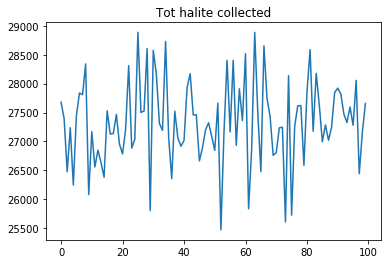

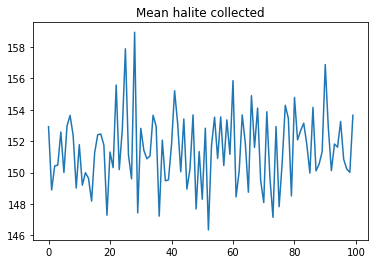

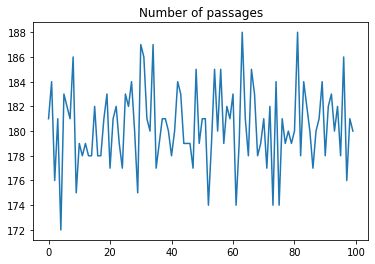

In [48]:
plt.plot(h_tot)
plt.title("Tot halite collected")
plt.show()
plt.title("Mean halite collected")
plt.plot(h_mean)
plt.show()
plt.title("Number of passages")
plt.plot(passages_vec)
plt.show()

## Ideas

1. encode just the halite carried with more levels
2. give a more negative baseline for the reward when depositing halite

In [6]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
H_LEV = 3 # halite levels
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*H_LEV**6*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 40 #100 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01
LEARNING_RATE = 0.1
EPS_START = 0.5

Total number of states to be experienced:  142884


In [7]:
# convert all the parameters to dictionaries
env_dict = dict(NUM_PLAYERS = NUM_PLAYERS , 
                TOT_TURNS = TOT_TURNS)

state_dict = dict(MAP_SIZE = MAP_SIZE,  
                  H_LEV = H_LEV, 
                  N_ACTIONS = N_ACTIONS)

learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = EPS_START, 
                     STD_REWARD = STD_REWARD)

In [8]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained

In [10]:
def play_episode(q_values, eps, NUM_PLAYERS, MAP_SIZE, TOT_TURNS, N_ACTIONS, H_LEV,
                 STD_REWARD,LEARNING_RATE, DISCOUNT_FACTOR, verbose = False):
    """
    Trains the agent by playing one episode of halite.
    
    Parameters
    ----------
    q_values         : numpy array 
        Contains the Q-values
    eps              : float 
        Represents a probability, must be in [0,1], controls the probability of exploring instead of exploting
    NUM_PLAYERS      : int
    MAP_SIZE         : int
    TOT_TURNS        : int
    N_ACTIONS        : int
    H_LEV            : int
    STD_REWARD       : float
        Baseline reward given to the agent when does not deposit halite to the shipyard
    LEARNING_RATE    : float
    DISCOUNT_FACTOR  : float
        Must be greater than 0 but smaller than 1. Suggested 1-1/TOT_TURNS or 1
    verbose          : bool
        Prints halite of the player at each turn of the game
        
    Returns
    -------
    q_values         : numpy array 
        Updated Q-values
    reward           : float
        Reward obtained in this episode. 
    collected_halite : float
        Halite collected by the agent.
    passages         : int
        Number of passages of the ship through the shipyard.
    """
    env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
    steps = 0
    reward = 0 # cumulative reward of the episode
    passages = 0 # number of times the ship passes through the shipyard
    
    # first mandatory step
    steps = steps + 1
    if verbose:
        print("\nStep number %d:"%steps)
    action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
    shipyard_action = True # initially always choose to create a ship
    # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
    state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
    #print("Cargo layer: \n", state[:,:,2])
    current_halite = players_halite[0][0]
    s_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)

    while True:
        steps = steps + 1
        if verbose:
            print("\nStep number %d:"%steps)
            print("Current halite: ", current_halite)
        a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
        a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form

        # submit the action and get the new state
        state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

        new_halite = players_halite[0][0]

        # compute the 1-ship reward as the halite increment of the player divided by the max halite 
        # plus a standard negative reward 
        #---------------------------------------------------------------------------------------------------------
        if new_halite == current_halite:
            r =  STD_REWARD
        else:
            r = (new_halite - current_halite)/1000 + STD_REWARD*50 # this is the change in the code
        #---------------------------------------------------------------------------------------------------------
        sp_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
        reward += r # cumulative reward of the episode

        # adds 1 to passages if the current position of the ship coincides with that of the shipyard
        # whereas the previous position didn't
        s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
        if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
            passages = passages +1
                
        a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

        # update Q-values
        q_values = ship.update_q_v1(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, alpha = LEARNING_RATE,
                    gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS)

        # update states and halite
        s_enc = sp_enc
        current_halite = new_halite

        if (finish == True) or (steps >= 400):
            if verbose:
                print("\nEnd episode.")
            break
    collected_halite = current_halite - 4000
    return q_values, reward, collected_halite, passages

<IPython.core.display.Javascript object>


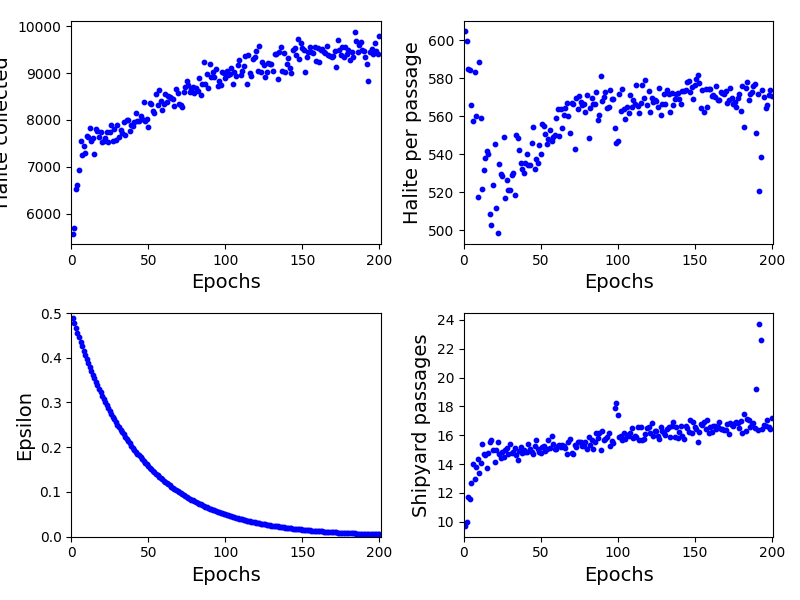

Hey, I think you've had enough! Let's stop here.


In [11]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(MAX_EPOCHS)
halite_score = np.zeros(MAX_EPOCHS)
shipy_pass = np.zeros(MAX_EPOCHS)
epochs = 0
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))


# visualize online the results
%matplotlib notebook
fig = plt.figure(figsize = (8,6))
plt.ion()

ax1 = fig.add_subplot(221)
ax1.set_xlim(0,MAX_EPOCHS+1)
#ax1.set_ylim(0,9000)
ax1.set_xlabel("Epochs", fontsize = 14)
ax1.set_ylabel("Halite collected", fontsize = 14)

ax2 = fig.add_subplot(222)
ax2.set_xlim(0,MAX_EPOCHS+1)
#ax2.set_ylim(-4,5)
ax2.set_xlabel("Epochs", fontsize = 14)
ax2.set_ylabel("Halite per passage", fontsize = 14)


ax3 = fig.add_subplot(223)
ax3.set_xlim(0,MAX_EPOCHS+1)
ax3.set_ylim(0,0.5)
ax3.set_xlabel("Epochs", fontsize = 14)
ax3.set_ylabel("Epsilon", fontsize = 14)


ax4 = fig.add_subplot(224)
ax4.set_xlim(0,MAX_EPOCHS+1)
ax4.set_xlabel("Epochs", fontsize = 14)
ax4.set_ylabel("Shipyard passages", fontsize = 14)

plt.tight_layout()
fig.show()
fig.canvas.draw()

from tqdm import tnrange, trange

for k in tnrange(MAX_EPOCHS, desc='1st loop', leave=True):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    shipy_pass_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    eps = epsilons[epochs]
    # update the dictionary at each epoch with the new epsilon
    learning_dict = dict(LEARNING_RATE = 0.1, DISCOUNT_FACTOR = DISCOUNT_FACTOR , eps = eps, STD_REWARD = STD_REWARD)

    for i in tnrange(N_BATCH, desc='2nd loop', leave=False):
        # here starts an episode
        q_values, reward, collected_halite, passages = play_episode(q_values, **env_dict, **state_dict, **learning_dict)
        reward_progress[i] = collected_halite/passages
        halite_progress[i] = collected_halite
        shipy_pass_progress[i] = passages

        #break # play just 1 episode

    #break # play just 1 epoch

    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()
    shipy_pass[epochs-1] = shipy_pass_progress.mean()
    
    ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
    ax2.scatter(epochs, reward_score[epochs-1], s = 10,color='blue')
    ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
    ax4.scatter(epochs, shipy_pass[epochs-1], s = 10, color='blue')
    fig.canvas.draw()

    if epochs >= MAX_EPOCHS:
        print("Hey, I think you've had enough! Let's stop here.")
        break

In [13]:
np.save("Q_values/q_values_500penalty_30batches.npy", q_values)